In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [2]:
data = pd.read_csv('healthcare_dataset.csv', delimiter=',', encoding='ISO-8859-1')
data = data.drop(columns=['Name', 'Doctor'])
data.head()

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,30,Male,B-,Cancer,2024-01-31,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,62,Male,A+,Obesity,2019-08-20,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,76,Female,A-,Obesity,2022-09-22,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,28,Female,O+,Diabetes,2020-11-18,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,43,Female,AB+,Cancer,2022-09-19,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [3]:
print(f'\n{data.info()}\n, \n{data.describe()}, \n{data.isnull().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 55500 non-null  int64  
 1   Gender              55500 non-null  object 
 2   Blood Type          55500 non-null  object 
 3   Medical Condition   55500 non-null  object 
 4   Date of Admission   55500 non-null  object 
 5   Hospital            55500 non-null  object 
 6   Insurance Provider  55500 non-null  object 
 7   Billing Amount      55500 non-null  float64
 8   Room Number         55500 non-null  int64  
 9   Admission Type      55500 non-null  object 
 10  Discharge Date      55500 non-null  object 
 11  Medication          55500 non-null  object 
 12  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 5.5+ MB

None
, 
                Age  Billing Amount   Room Number
count  55500.000000    55500.00000

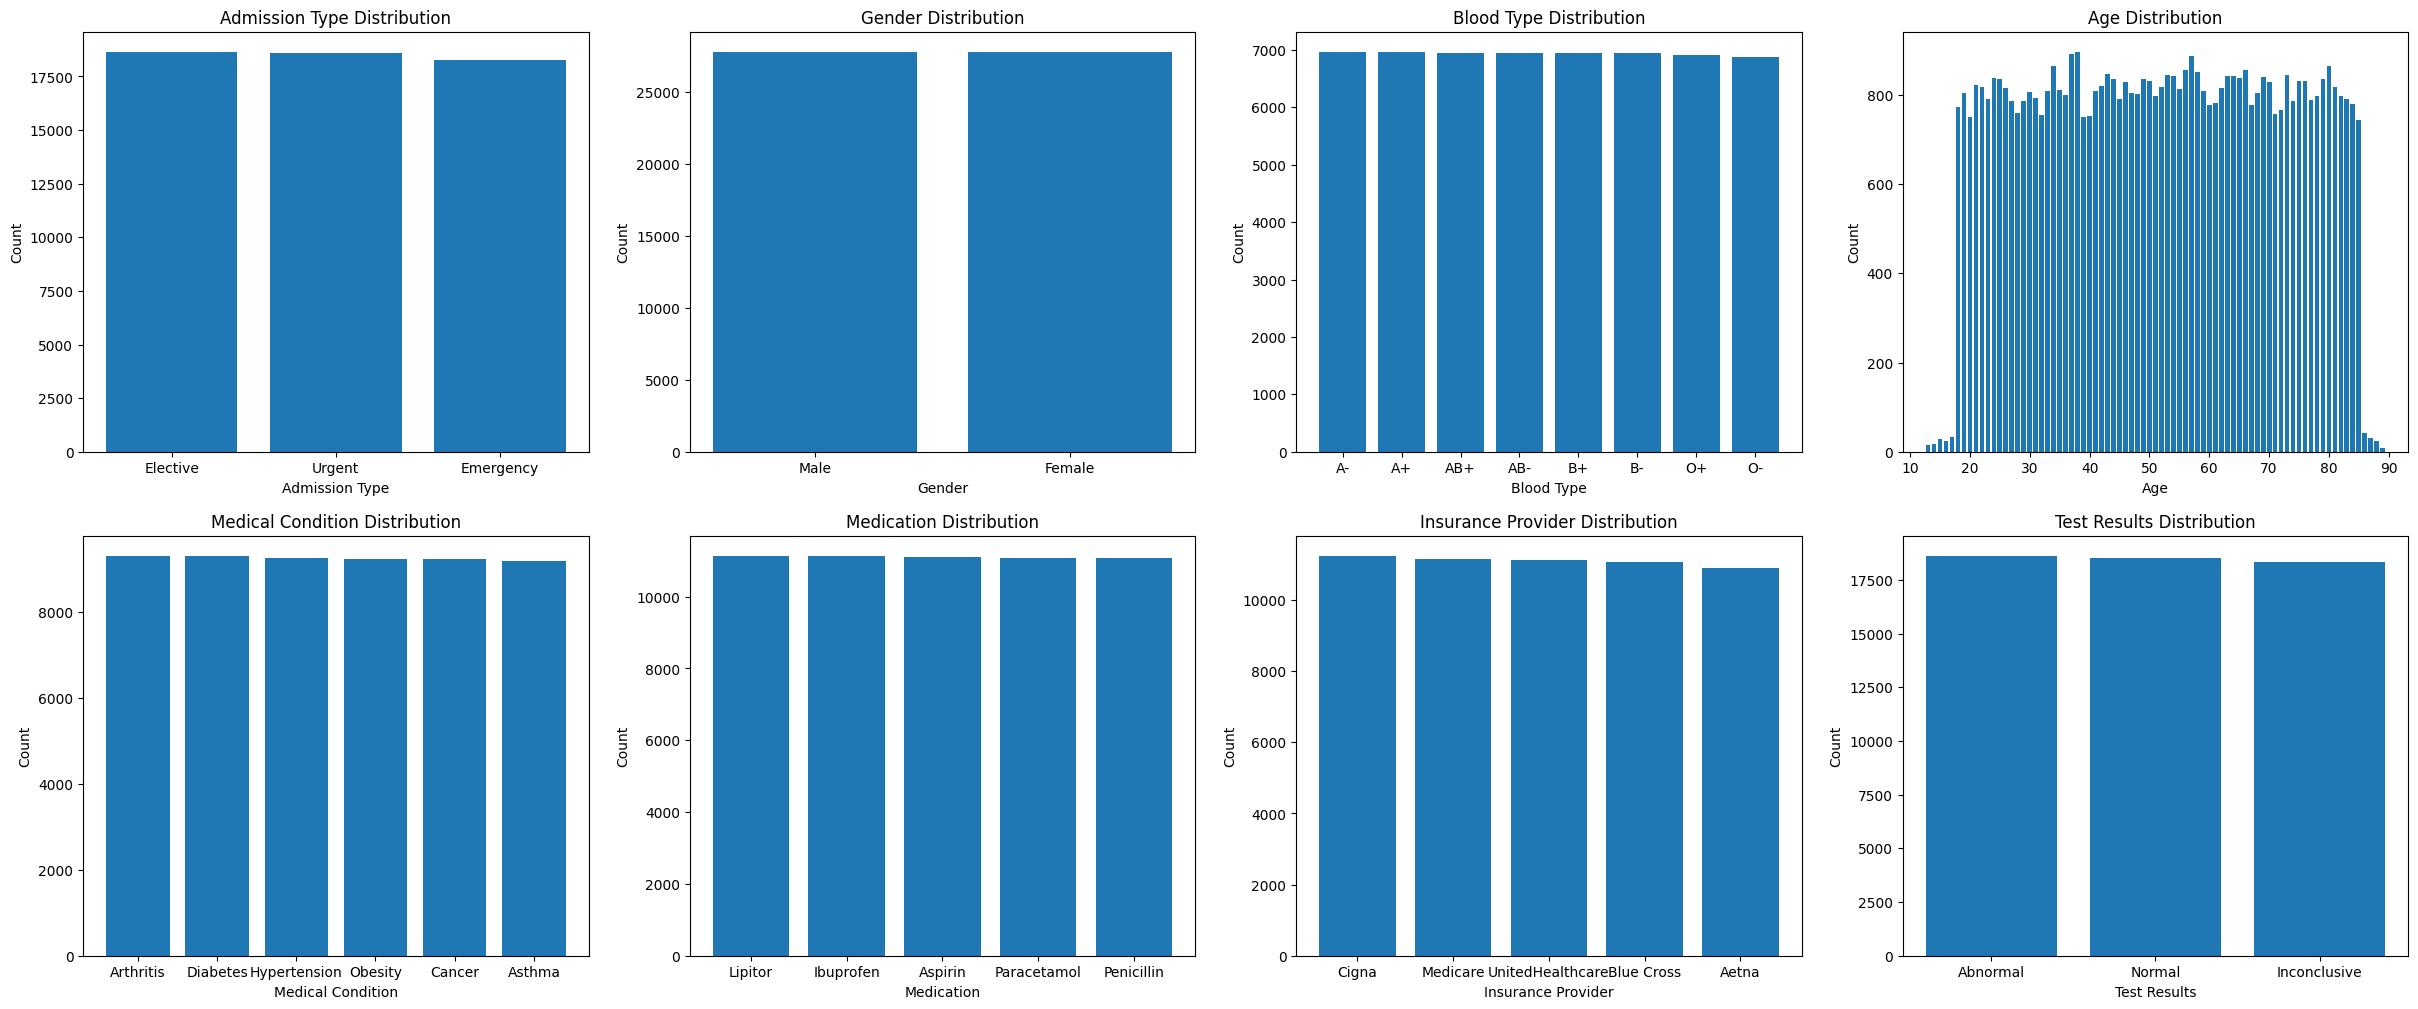

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

variables = ['Admission Type', 'Gender', 'Blood Type', 'Age', 'Medical Condition', 'Medication', 'Insurance Provider', 'Test Results']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel(var)

In [38]:
'''def group_rare_categories(column, threshold=0.01):
    counts = column.value_counts(normalize=True)
    return column.apply(lambda x: x if counts[x] > threshold else 'Other')

low_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']
high_cardinality_cols = ['Insurance Provider']

for col in high_cardinality_cols:
    data[col] = group_rare_categories(data[col])'''

"def group_rare_categories(column, threshold=0.01):\n    counts = column.value_counts(normalize=True)\n    return column.apply(lambda x: x if counts[x] > threshold else 'Other')\n\nlow_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']\nhigh_cardinality_cols = ['Insurance Provider']\n\nfor col in high_cardinality_cols:\n    data[col] = group_rare_categories(data[col])"

In [5]:
low_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']
high_cardinality_cols = ['Insurance Provider']

In [6]:
data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
data['Length of Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
data = data.drop(['Date of Admission', 'Discharge Date', 'Hospital'], axis=1)

In [7]:
encoder = OneHotEncoder()
low_cardinality_cols_encoded = {}
encoder_names = []
for col in data[low_cardinality_cols]:
    low_cardinality_cols_encoded[col] = encoder.fit_transform(data[[col]]).toarray()
    encoder_names.extend(encoder.categories_)
column_names = [name for names in encoder_names for name in names]
encoded_arrays = [low_cardinality_cols_encoded[col] for col in low_cardinality_cols]
encoded_data = np.hstack(encoded_arrays)
encoded_df = pd.DataFrame(encoded_data, columns=column_names)

In [ ]:
#data = pd.get_dummies(data, columns=low_cardinality_cols, drop_first=True)
#columns = ['Test Results','Age','Length of Stay','Billing Amount','Room Number']

In [8]:
label_encoders = {}
for col in high_cardinality_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])
label_encoder = LabelEncoder()
data['Test Results'] = label_encoder.fit_transform(data['Test Results'])

In [9]:
Cleaned_data = pd.concat([data.drop(columns=low_cardinality_cols), encoded_df ], axis=1)

In [10]:
Cleaned_data

,Age,Insurance Provider,Billing Amount,Room Number,Test Results,Length of Stay,Female,Male,A+,A-,...,Hypertension,Obesity,Elective,Emergency,Urgent,Aspirin,Ibuprofen,Lipitor,Paracetamol,Penicillin
0,30,1,18856.281306,328,2,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,62,3,33643.327287,265,1,6,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,76,0,27955.096079,205,2,15,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,28,3,37909.782410,450,0,30,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,43,0,14238.317814,458,0,20,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,42,1,2650.714952,417,0,30,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
55496,61,2,31457.797307,316,2,9,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55497,38,4,27620.764717,347,0,28,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
55498,43,3,32451.092358,321,0,6,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
X = Cleaned_data.drop(columns=['Test Results'])
y = Cleaned_data['Test Results']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [12]:
Scaler = StandardScaler()
X_train_scaled = pd.DataFrame(Scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(Scaler.transform(X_test), columns=X_train.columns, index=X_test.index)

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

y_pred_test = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)
print(f'Train Set accuracy score:{metrics.accuracy_score(y_train, y_pred_train):,.4f}\nF1-Score for Train Set:{metrics.f1_score(y_test, y_pred_test, average='macro'):,.4f}')
print(f'\nTest Set accuracy score:{metrics.accuracy_score(y_test, y_pred_test):,.4f}\nF1-Score for Test Set:{metrics.f1_score(y_test, y_pred_test, average='macro'):,.4f}')

Train Set accuracy score:0.3445
F1-Score for Train Set:0.3373

Test Set accuracy score:0.3385
F1-Score for Test Set:0.3373


In [14]:
svc = SVC(kernel='rbf', C=1, gamma=0.1)
svc.fit(X_train_scaled, y_train)

svc_y_pred = svc.predict(X_test_scaled)
svc_y_pred_train = svc.predict(X_train_scaled)

print(f'Train Set accuracy score:{metrics.accuracy_score(y_train, svc_y_pred_train):,.4f}\nF1-Score for Train Set:{metrics.f1_score(y_test, svc_y_pred, average='macro'):,.4f}')
print(f'\nTest Set accuracy score:{metrics.accuracy_score(y_test, svc_y_pred):,.4f}\nF1-Score for Test Set:{metrics.f1_score(y_test, svc_y_pred, average='macro'):,.4f}')

Train Set accuracy score:0.6408
F1-Score for Train Set:0.3784

Test Set accuracy score:0.3785
F1-Score for Test Set:0.3784


In [25]:
folds = KFold(n_splits=3, shuffle=True, random_state=7)
_model = GaussianNB()

In [28]:
params = {'C':[0.1, 1, 10],
          'gamma':[1, 0.1, 0.01],
          'kernel':['rbf', 'linear', 'poly'],
          'degree':[1,2,3]}

In [30]:
param = {'var_smoothing':[1e-9, 1e-8, 1e-7, 1e-6,
                          1e-5, 1e-4, 1e-3]}

In [33]:
grid_search = RandomizedSearchCV(estimator=_model, param_distributions=param, 
                           scoring='f1_macro', cv=folds, n_jobs=-1, n_iter=20,
                           verbose=1, return_train_score=True
                           )
grid_search.fit(X_train_scaled, y_train)
results = pd.DataFrame(grid_search.cv_results_)
print(grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_)

C:\Users\soule\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 7 candidates, totalling 21 fits
GaussianNB() {'var_smoothing': 1e-09} 0.3334366783798575


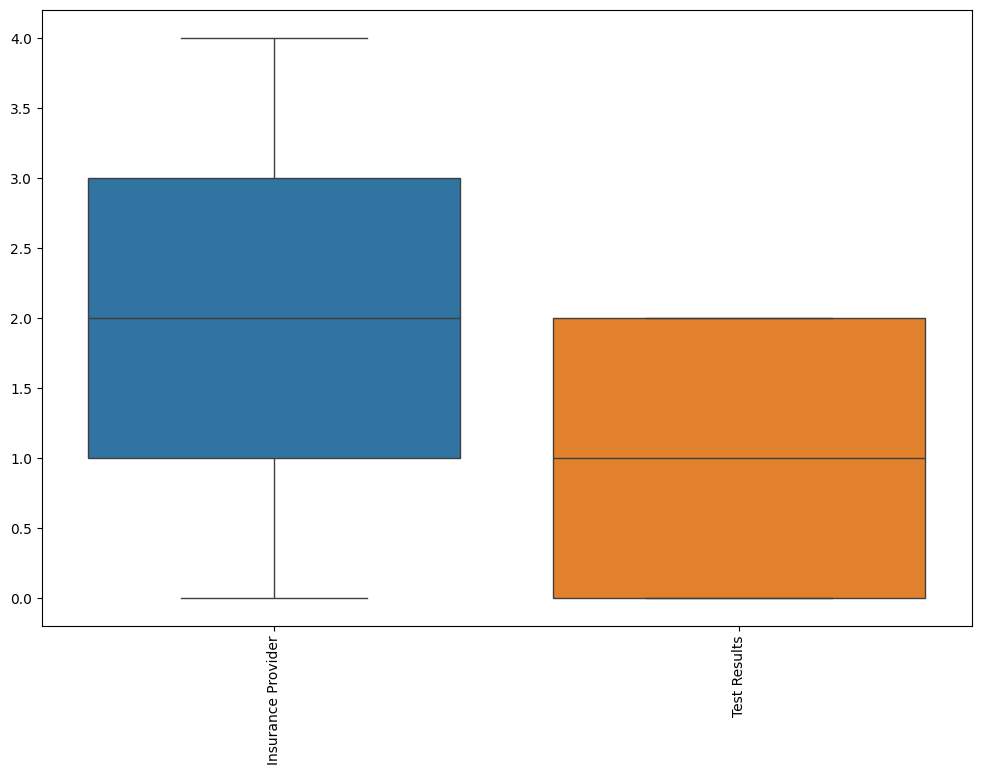

In [45]:
filtered = data[['Insurance Provider', 'Medication', 'Test Results', 'Gender', 'Blood Type', 'Medical Condition', 'Admission Type']]

numeric_cols = filtered.select_dtypes(include=['number'])

lower_bounds = []
upper_bounds = []

for col in numeric_cols.columns:
    Q1 = np.percentile(numeric_cols[col], 25)
    Q3 = np.percentile(numeric_cols[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)
    
    filtered = filtered[(filtered[col] >= lower_bound) & (filtered[col] <= upper_bound)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()


In [12]:
X = data[['Room Number', 'Billing Amount','Age','Length of Stay']]
y = data['Test Results']

f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'p-value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

print("ANOVA F-Test Results:")
anova_results

ANOVA F-Test Results:


,Feature,F-Value,p-value
2,Age,1.849758,0.157285
1,Billing Amount,0.636811,0.528981
0,Room Number,0.402548,0.668616
3,Length of Stay,0.379228,0.684391


In [13]:
categorical_cols = data.drop(columns=['Room Number', 'Billing Amount','Test Results','Age','Length of Stay'])

chi2_results = []
for feature in categorical_cols:
    contingency_table = pd.crosstab(data[feature], data['Test Results'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results.append((feature, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi-Square', 'P-Value'])
chi2_df.sort_values(by='P-Value', inplace=True)
chi2_df

,Feature,Chi-Square,P-Value
2,Medical Condition,13.255076,0.209758
0,Gender,2.018351,0.364519
3,Insurance Provider,8.377554,0.397485
4,Admission Type,1.319806,0.858006
5,Medication,3.731141,0.880530
1,Blood Type,7.631683,0.907619


In [14]:
from sklearn.pipeline import make_pipeline

X = data.drop(columns=['Test Results'])
y = data['Test Results']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = make_pipeline(StandardScaler(), LogisticRegression(), KNeighborsClassifier(n_neighbors=3), SVC(kernel='linear'), RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), GradientBoostingClassifier())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

'''Decision Tree, Neural Networks , SVM , KNN , Naive Bayes , Gradient Boosting Machines (GBM) — XGBoost'''

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'LogisticRegression()' (type <class 'sklearn.linear_model._logistic.LogisticRegression'>) doesn't

In [ ]:
import statsmodels.api as sm

x2 = sm.add_constant(X_train)
model_train = sm.OLS(y_train, x2)
model_fit = model_train.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Test Results   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2694
Date:                Tue, 25 Jun 2024   Prob (F-statistic):              0.988
Time:                        18:06:16   Log-Likelihood:                -54044.
No. Observations:               44400   AIC:                         1.081e+05
Df Residuals:                   44389   BIC:                         1.082e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0073      0.022     45.692      0.000       0.964       1.051
Age                   -0.0003      0.000     -1.276      0.202      -0.001       0.000
Gender                 0.0036      0.008      0.460      0.646      -0.012       0.019
Blood Type            -0.0003      0.002     -0.202      0.840      -0.004       0.003
Medical Condition      0.0010      0.002      0.458      0.647      -0.003       0.005
Insurance Provider     0.0005      0.003      0.195      0.845      -0.005       0.006
Billing Amount     -1.796e-07   2.72e-07     -0.659      0.510   -7.14e-07    3.54e-07
Room Number         1.096e-05   3.37e-05      0.325      0.745    -5.5e-05     7.7e-05
Admission Type         0.0003      0.005      0.059      0.953      -0.009       0.010
Medication            -0.0003      0.003     -0.122      0.903      -0.006       0.005
Length of Stay      7.397e-05      0.000      0.165      0.869      -0.001       0.001
==============================================================================
Omnibus:                   265404.017   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4178.630
Skew:                           0.003   Prob(JB):                         0.00
Kurtosis:                       1.497   Cond. No.                     1.67e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
'''new_pred = model.predict(pd.DataFrame([[1,0,6]]))

if new_pred == 2:
    print('Normal')
elif new_pred == 1:
    print('Inconclusive')
else:
    print('Abnormal')'''

"new_pred = model.predict(pd.DataFrame([[1,0,6]]))\n\nif new_pred == 2:\n    print('Normal')\nelif new_pred == 1:\n    print('Inconclusive')\nelse:\n    print('Abnormal')"